# Imports

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from abba import ABBA, ABBA_like

# Sin wave tests

## ABBA transformation and reconstruction

In [3]:
np.random.seed(42)
torch.manual_seed(42)

N = 200
t = np.linspace(0, 20, N)
series = np.sin(t) + 0.1 * np.random.randn(N)

In [4]:
n_symbols = 12
window_size = 20

abba_like = ABBA_like(n_symbols=n_symbols, window_size=window_size)
symbol_sequence = abba_like.fit(series)
symbol_sequence

array([10, 10,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10, 10, 10,  5,  5,  5,
        2,  2,  2,  6,  6,  6, 11, 11, 11,  1,  1,  1,  7,  7,  7,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,  7,  7,  9,  9,  9,  4,
        4,  4,  8,  8,  8,  2,  2,  5,  5,  5, 10, 10, 10,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 10, 10, 10,  5,  5,  5,  2,  2,  2,  6,  6,
        6, 11, 11, 11,  1,  1,  1,  7,  7,  7,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  7,  7,  7,  7,  9,  9,  9,  9,  4,  4,  4,  8,  8,  8,
        2,  2,  5,  5,  5, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       10, 10, 10,  5,  5,  5,  2,  2,  2,  2,  6,  6,  6, 11, 11, 11,  1,
        1,  1,  7,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,  7,
        7,  7,  9,  9,  9,  4,  4,  4,  8,  8,  8], dtype=int32)

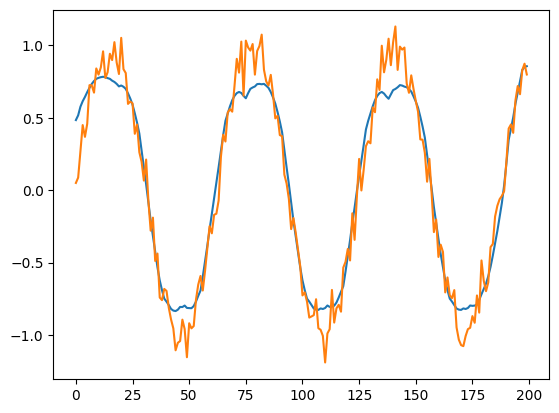

In [5]:
recon_smooth = abba_like.inverse_transform_smooth(symbol_sequence)
plt.plot(recon_smooth)
plt.plot(series)

In [9]:
abba = ABBA()
symbol_sequence = abba.fit(series)
symbol_sequence

array([ 92,  30, 118,  74,  41,  28, 133, 122, 101,  65, 123,  53, 160,
        80,  43, 132, 134, 108, 124,   6,  34,  54,  61,  13,  42, 156,
        15, 117, 155, 148,   2,  84,   1,  35, 130,  66,  22, 146,  16,
       142,  98,  75,  18, 113, 139,  81, 150,  26, 131, 135,  87,  83,
        21, 106,  60,  32,  45,  33, 125, 119,  59,   0,  23, 157,  25,
        86, 137,  57, 112, 161,  71,  99,  52,  56,  36, 138,  97,  40,
       109,  62, 140, 104,  90,  67,   4,   3, 145, 120, 162, 158,  10,
        70, 147,  93, 127, 152, 126,  31,  47,  37,  79,  82,  44, 105,
        14,  94,  29,  50, 128,  12, 149, 100,  49, 144,  78, 114,  46,
       103,   7, 111, 102,  39,  85, 153, 141,  11,   8, 151,  24,  69,
       159, 129,  27, 154,  73,   9,  89,  55,  38, 110,  19, 116,  72,
       136,  88,  58,  48,  51, 107, 115,  91,  20,  63, 143,  17,   5,
        68, 121,  77,  96,  95,  76,  64], dtype=int32)

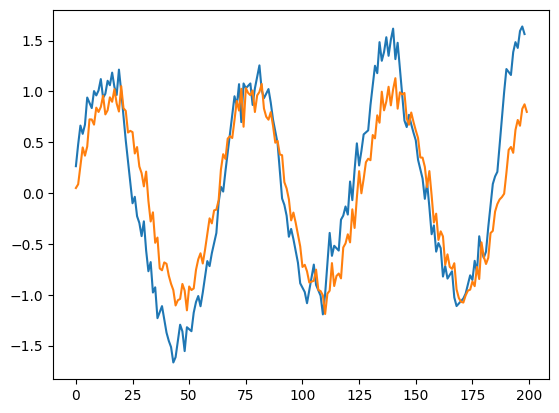

In [12]:
recon = abba.inverse_transform(symbol_sequence, series[0])
plt.plot(recon)
plt.plot(series)

## LSTM Prediction

In [ ]:
from models.LSTM import TimeSeriesLSTM
from train_LSTM import train_model

model = TimeSeriesLSTM()
train_model(model, series, 10, device='cuda')

/home/onyxia/work/ABBA_LSTM/utils/data_handler.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(X).unsqueeze(-1)


Epoch [10/200] Train: 0.126888 Val: 0.141110
Epoch [20/200] Train: 0.060316 Val: 0.072899
Epoch [30/200] Train: 0.013885 Val: 0.012435
Epoch [40/200] Train: 0.012778 Val: 0.011240
Epoch [50/200] Train: 0.012581 Val: 0.011084
Epoch [60/200] Train: 0.012459 Val: 0.011003
Epoch [70/200] Train: 0.012363 Val: 0.010952
Epoch [80/200] Train: 0.012278 Val: 0.010912
Epoch [90/200] Train: 0.012198 Val: 0.010880


Epoch [100/200] Train: 0.012121 Val: 0.010852
Epoch [110/200] Train: 0.012047 Val: 0.010829
Epoch [120/200] Train: 0.011977 Val: 0.010813
Epoch [130/200] Train: 0.011913 Val: 0.010802
Epoch [140/200] Train: 0.011851 Val: 0.010798
Epoch [150/200] Train: 0.011787 Val: 0.010798
Epoch [160/200] Train: 0.011722 Val: 0.010798
Early stopping à l'epoch 161 (best val loss = 0.010798)


In [ ]:
lag=10
initial_series = torch.tensor(series, dtype=torch.float)  # batch=1
forecast = model.forecast(initial_series, horizon=20)

/tmp/ipykernel_5746/3278125454.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  forecast = np.array(forecast)


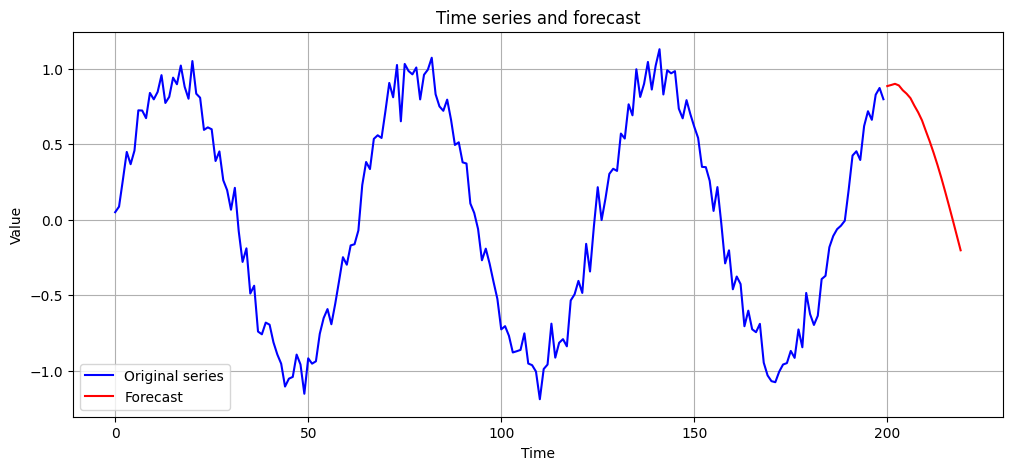

In [ ]:
series = np.array(series)
forecast = np.array(forecast)

N = len(series)
H = len(forecast)

plt.figure(figsize=(12, 5))

plt.plot(range(N), series, label="Original series", color="blue")
plt.plot(range(N, N + H), forecast, label="Forecast", color="red")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time series and forecast")
plt.legend()
plt.grid(True)

plt.show()

## ABBA-LSTM Prediction

In [18]:
n_symbols = len(abba.symbol_map.keys())

In [19]:
from models.ABBA_LSTM import ABBALSTM
from train_ABBALSTM import train_model

model = ABBALSTM(n_symbols)
train_model(model, symbol_sequence, 10, device='cuda')

Epoch [10/200] Train: 4.906197 Val: 5.261053
Early stopping à l'epoch 16 (best val loss = 5.138014)


In [20]:
symbols_forecast = model.forecast(
    torch.tensor(symbol_sequence, dtype=torch.long),  # torch.LongTensor (lag,)
    horizon=10
)
symbols_forecast

[142, 90, 90, 90, 90, 90, 90, 90, 90, 90]

In [22]:
numeric_forecast = abba.inverse_transform(symbols_forecast, series[-1])
numeric_forecast

array([ 0.73347027,  0.5310986 ,  0.32872693,  0.12635525, -0.07601642,
       -0.27838809, -0.48075976, -0.68313143, -0.8855031 , -1.08787477])

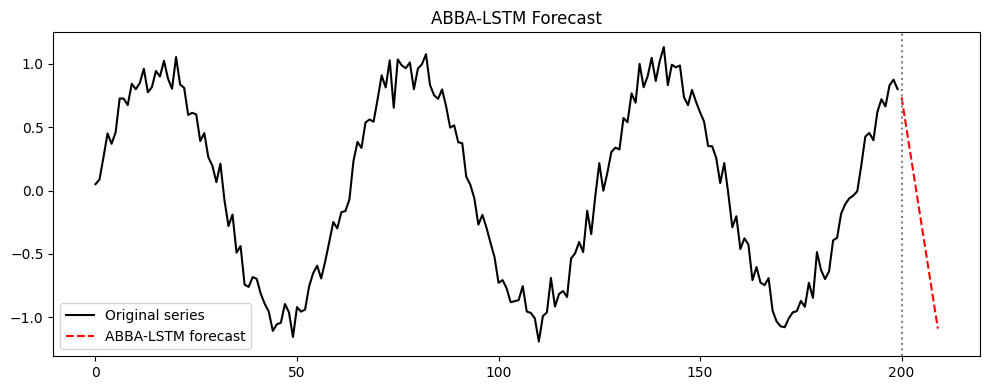

In [23]:
plt.figure(figsize=(10, 4))

# Série originale
plt.plot(
    np.arange(len(series)),
    series,
    label="Original series",
    color="black"
)

# Forecast
plt.plot(
    np.arange(len(series), len(series) + len(numeric_forecast)),
    numeric_forecast,
    label="ABBA-LSTM forecast",
    color="red",
    linestyle="--"
)

plt.axvline(len(series), color="gray", linestyle=":")
plt.legend()
plt.title("ABBA-LSTM Forecast")
plt.tight_layout()
plt.show()

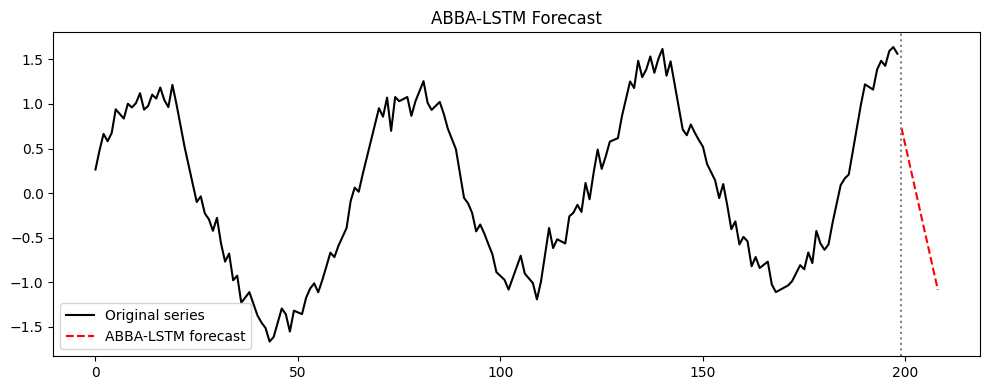

In [24]:
plt.figure(figsize=(10, 4))

# Série originale
plt.plot(
    np.arange(len(recon)),
    recon,
    label="Original series",
    color="black"
)

# Forecast
plt.plot(
    np.arange(len(recon), len(recon) + len(numeric_forecast)),
    numeric_forecast,
    label="ABBA-LSTM forecast",
    color="red",
    linestyle="--"
)

plt.axvline(len(recon), color="gray", linestyle=":")
plt.legend()
plt.title("ABBA-LSTM Forecast")
plt.tight_layout()
plt.show()